In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import networkx as nx
import math
import matplotlib.pyplot as plt
import time

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# Sets default tensor to be allocated on device if CUDA is available
if torch.cuda.is_available():
    torch.set_default_device('cuda')

In [4]:
n = 10
seq_length = int((n*(n-1))/2)  # Length of the desired sequence
input_size = 2*seq_length
hidden_size_1 = 128 # Size of the hidden layer of the neural network
hidden_size_2 = 64
hidden_size_3 = 4
output_size = 1  # Outputs a probability for the next entry

In [5]:
# Constructs the model
# Note: the model takes a binary vector twice the length of the desired sequence,
# and outputs the probability that the next entry of the sequence is a "1".
# The first half of the input consists of the sequence constructed so far. The second
# half is an indicator of the entry that we are generating (as in Wagner's paper).
# For example if the input is 0 1 0 0 0 1, then the sequence constructed so far
# is 0 1 and the last three entries "0 0 1" indicate that we are currently choosing
# the last entry.
class Net(nn.Module):
  def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
    super(Net,self).__init__()
    self.nn_stack = nn.Sequential(
        nn.Linear(input_size, hidden_size_1),
        nn.ReLU(),
        nn.Linear(hidden_size_1, hidden_size_2),
        nn.ReLU(),
        nn.Linear(hidden_size_2, hidden_size_3),
        nn.ReLU(),
        nn.Linear(hidden_size_3, output_size),
        nn.Sigmoid()
    )

  def forward(self, x):
    y = self.nn_stack(x)
    return(y)
  def optimize(self, input, output):
    self.train()
    for input_seq, target in zip(input, output):
      input_seq = input_seq.to(device)
      target = target.to(device)
      optimizer.zero_grad()
      pred = self(input_seq)
      loss = criterion(pred, torch.tensor([target], device = device))
      loss.backward()
      optimizer.step()
    return loss.item()

In [6]:
LEARNING_RATE = 0.0001

model = Net(input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss() # Using binary cross entropy loss
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.1, patience=10)

In [7]:
# Function to generate a new sequence.
def generate_sequence(length):
  seq = torch.zeros(length)  # Actual sequence
  ind = torch.zeros(length)  # Indicator of location
  for i in range(length):
    ind[i] = 1
    seq_con = torch.concatenate([seq, ind])
    prob = model.forward(seq_con)
    if np.random.rand(1)[0] <= prob:
      seq[i] = 1
    ind[i] = 0
  return(seq)

In [8]:
# Generates a matrix whose rows are binary sequences generated using the neural net model
def generate_seq_matrix(N, length):
  mat = torch.zeros(N,length)
  for i in range(N):
    new_seq = generate_sequence(length)
    mat[i,:] = new_seq
  return(mat)

In [9]:
def sequence_to_adjacency_matrix(seq_matrix, n):
    # Initialize an nxn adjacency matrix of zeroes
    # n = degree
    adj_matrix = np.zeros((n, n), dtype=int)
    k = 0
    # Add the edges between vertices to the adjacency matrix
    for i in range(n):
        for j in range(i + 1, n):
            if seq_matrix[k] == 1:
                adj_matrix[i][j] = 1
                adj_matrix[j][i] = 1
            k += 1
    return adj_matrix

In [10]:
def find_largest_eigenvalue(adj_matrix):
    adj_matrix = np.array(adj_matrix)
    eigenvalues = np.linalg.eigvals(adj_matrix)
    largest_eigenvalue = np.max(np.abs(eigenvalues))
    return largest_eigenvalue

In [11]:
def find_matching_number(adj_matrix):
    graph = nx.Graph(adj_matrix)
    matching = nx.max_weight_matching(graph, maxcardinality=True)
    return len(matching)

In [12]:
# Penalty
penalty = -1000

# Reward function
def reward_fcn(seq):
  adj_matrix = sequence_to_adjacency_matrix(seq, n)
  G = nx.Graph(adj_matrix)
  #if not (nx.is_connected(nx.Graph(adj_matrix))):
        #return penalty, 0
  # we know this is false for simple graphs M <= 2|E|/|V|, so construct max{deg(V)} - 2|E|/|V| <= 0 and find a counterexample
  if not (len(list(nx.simple_cycles(G))) == 0):
      return penalty, 0
  seq_int = seq.to(torch.int)
  #num_edges = (seq == 1).sum()
  num_edges = G.number_of_edges()
  max_degree = max([val for (node, val) in G.degree()])
  score = ((3.5 * num_edges) / n) - max_degree
  counterexample_found = 1 if score > 0 else 0
  return score, counterexample_found

In [13]:
# Pick the top sequences (according to the reward function) from a matrix of sequences
# seq_matrix = N x seq_length matrix consisting of N binary sequences
# top_perc = percentage of top sequences to keep
def elite_sequences(seq_matrix, top_perc):
  N = seq_matrix.shape[0]
  reward_vec = torch.zeros(N)
  counterexample_found = 0
  counterexample_graph = None
  for i in range(N):
    reward_vec[i], counterex = reward_fcn(seq_matrix[i,:])
    if counterex:
        counterexample_found = 1
        counterexample_graph = nx.Graph(sequence_to_adjacency_matrix(seq_matrix[i,:], n))
  num_samples = int(np.round(top_perc*N))
  elite_indices = torch.argsort(reward_vec, descending=True)[0:num_samples]
  elite_matrix = seq_matrix[elite_indices,:]
  return elite_matrix, counterexample_found, counterexample_graph, torch.mean(reward_vec[elite_indices]).item()

In [14]:
# Create input/output pairs for a given matrix of sequences
def create_pairs(seq_matrix):
  N, p = seq_matrix.shape
  input = torch.zeros(N*p, 2*p)
  output = torch.zeros(N*p)
  counter = 0
  for i in range(N):
    # Processing sequence i
    for j in range(p):
      # Index vector
      ind = torch.zeros(p)
      ind[j] = 1
      # Partial sequence
      seq = torch.zeros(p)
      seq[0:j+1] = seq_matrix[i,0:j+1]
      seq[j] = 0
      input[counter,:] = torch.concat([seq, ind])
      output[counter] = seq_matrix[i,j]
      counter += 1
  return([input, output])


BCE Loss: 0.6873767375946045 Average Number of Edges: 22.41428565979004 Average Reward: -1000.0
Iteration Runtime: 24.1266774 sec
tensor([[0., 0., 0.,  ..., 1., 0., 1.],
        [0., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 1., 1., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 1., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 1.]], device='cuda:0')


BCE Loss: 0.696782648563385 Average Number of Edges: 21.950000762939453 Average Reward: -1000.0
Iteration Runtime: 17.8203221 sec
tensor([[0., 0., 0.,  ..., 1., 0., 1.],
        [0., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 1., 1., 0.],
        ...,
        [1., 1., 0.,  ..., 1., 0., 1.],
        [1., 0., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 1., 1., 0.]], device='cuda:0')


BCE Loss: 0.7012622356414795 Average Number of Edges: 21.73684310913086 Average Reward: -1000.0
Iteration Runtime: 17.250118000000008 sec
tensor([[0., 0., 0.,  ..., 1., 0., 1.],
        [0., 1.,

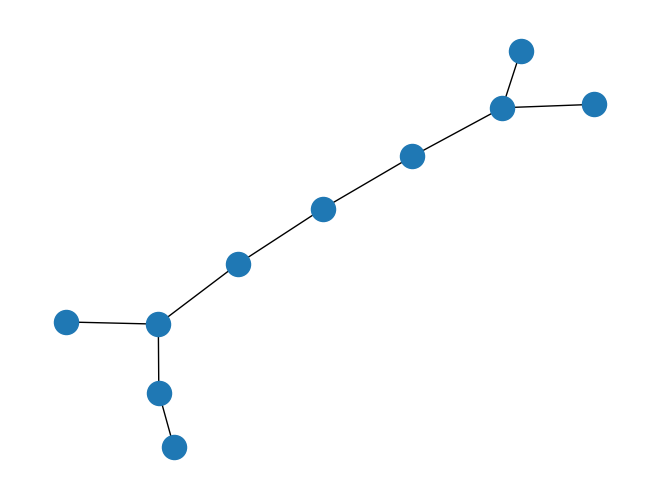

In [15]:
# Start training
batch_size = 500  # Number of generated sequences per training
num_train = 300 # Number of iterations

# Initialize the matrix of elites (top sequences)
current_elites = generate_seq_matrix(batch_size, seq_length)

counterexample_found = 0

program_start_time = time.perf_counter()
for i in range(num_train):
    iteration_start_time = time.perf_counter()
    if (counterexample_found):
        break
    # Generate new batch of sequences
    seq_mat = generate_seq_matrix(batch_size, seq_length)
    # Add new samples to elite matrix
    current_elites = torch.concat([current_elites, seq_mat])
    # Pick top X% samples
    current_elites, counterexample_found, counterexample_graph, reward_tracker = elite_sequences(current_elites, 0.07)
    # Create training data for the neural net model
    input, output = create_pairs(current_elites)
    input_on_device = input.to(device)
    output_on_device = output.to(device)
    # Optimizes the parameters of the model
    loss = model.optimize(input_on_device, output_on_device)
    #scheduler.step(loss)
    avg_elite_ones = current_elites.sum(axis=1).mean().item()
    print("BCE Loss:", loss, 'Average Number of Edges:', avg_elite_ones, "Average Reward:", reward_tracker)
    print("Iteration Runtime:", time.perf_counter() - iteration_start_time, "sec")
    print(current_elites)
    print("\n")
    # G = nx.Graph()
    # G.add_nodes_from(list(range(n)))
    # count = 0
    # for i in range(n):
    #     for j in range(i+1,n):
    #     	if current_elites[0].tolist()[count] == 1:
    #     		G.add_edge(i,j)
    #     	count += 1
    # plt.figure(figsize=(4, 4)) 
    # nx.draw(G)
    # plt.show()
print(current_elites)
print("Program Runtime:", time.perf_counter() - program_start_time, "seconds\n")
print("Counterexample found!")
nx.draw(counterexample_graph)
plt.show()

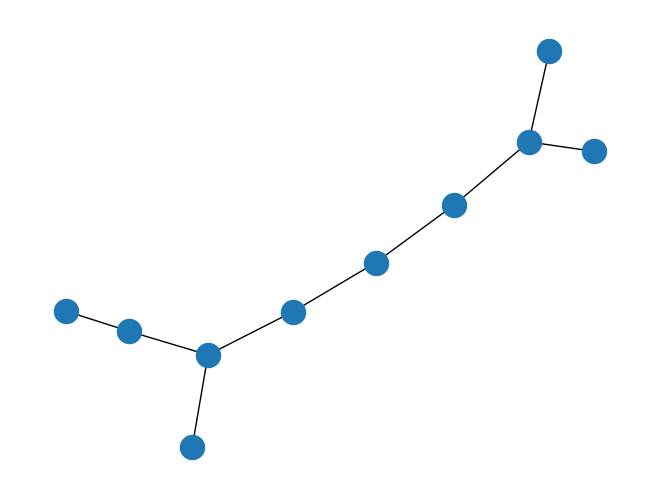

In [26]:
nx.draw(counterexample_graph)
plt.savefig("counterexample2.png", format="PNG")
plt.show()

In [22]:
num_edges = counterexample_graph.number_of_edges()
max_degree = max([val for (node, val) in counterexample_graph.degree()])
score = ((3.5 * num_edges) / n) - max_degree
print(score)

0.1499999999999999


In [17]:
A = sequence_to_adjacency_matrix(current_elites[0].tolist(), n)

In [18]:
print(A)

[[0 1 1 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 1]
 [0 0 0 1 1 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]]


In [19]:
eig = find_largest_eigenvalue(A)
mu = find_matching_number(A)
print(eig, " + ", mu, " = ", eig+mu)
print(math.sqrt(n-1) + 1)
print('Counterexample found') if (eig+mu < math.sqrt(n-1) + 1) else print('Not a counterexample')

2.0314421132823908  +  4  =  6.031442113282391
4.0
Not a counterexample


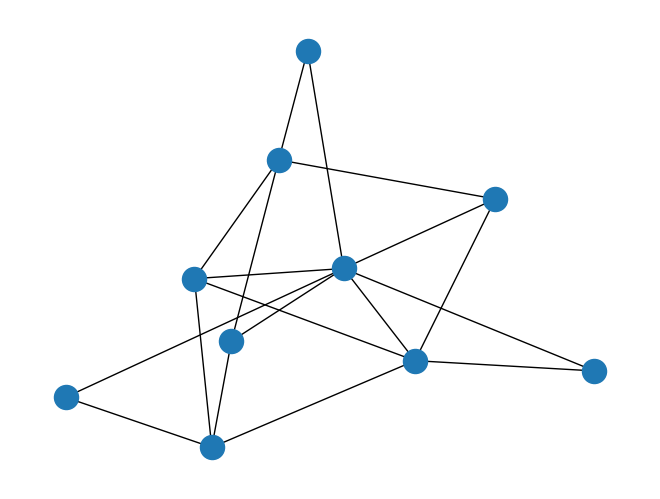

In [20]:
G = nx.Graph()
G.add_nodes_from(list(range(n)))
count = 0
for i in range(n):
	for j in range(i+1,n):
		if current_elites[-1].tolist()[count] == 1:
			G.add_edge(i,j)
		count += 1
nx.draw(G)
plt.show()